# Table of Contents
 <p><div class="lev1"><a href="#Optimize-Dynamic-Subgraphs"><span class="toc-item-num">1&nbsp;&nbsp;</span>Optimize Dynamic Subgraphs</a></div><div class="lev2"><a href="#Initialize-Environment"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev2"><a href="#Generate-List-of-Data"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Generate List of Data</a></div><div class="lev2"><a href="#Construct-Configuration-Matrices"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Construct Configuration Matrices</a></div><div class="lev2"><a href="#Parameter-Search-Space"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Parameter Search Space</a></div><div class="lev2"><a href="#Run-Non-Negative-Matrix-Factorization-Algorithm"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Run Non-Negative Matrix Factorization Algorithm</a></div><div class="lev2"><a href="#Analyze-Parameter-Search-Space"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Analyze Parameter Search Space</a></div><div class="lev3"><a href="#Display-Parameter-Search-Space"><span class="toc-item-num">1.6.1&nbsp;&nbsp;</span>Display Parameter Search Space</a></div><div class="lev3"><a href="#Display-Relationship-Between-Parameters-and-Quality-Measures"><span class="toc-item-num">1.6.2&nbsp;&nbsp;</span>Display Relationship Between Parameters and Quality Measures</a></div><div class="lev3"><a href="#Display-Bivariate-Distribution-of-Error-and-Sparsity"><span class="toc-item-num">1.6.3&nbsp;&nbsp;</span>Display Bivariate Distribution of Error and Sparsity</a></div><div class="lev3"><a href="#Find-Optimal-Parameters"><span class="toc-item-num">1.6.4&nbsp;&nbsp;</span>Find Optimal Parameters</a></div><div class="lev3"><a href="#Plot-closest-optimization-example"><span class="toc-item-num">1.6.5&nbsp;&nbsp;</span>Plot closest optimization example</a></div><div class="lev1"><a href="#Detect-Dynamic-Subgraphs"><span class="toc-item-num">2&nbsp;&nbsp;</span>Detect Dynamic Subgraphs</a></div><div class="lev2"><a href="#Initialize-Environment"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Initialize Environment</a></div><div class="lev2"><a href="#Run-Non-Negative-Matrix-Factorization-Algorithm"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Run Non-Negative Matrix Factorization Algorithm</a></div><div class="lev2"><a href="#Consensus-NMF"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Consensus NMF</a></div><div class="lev2"><a href="#Consensus-Subgraphs"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Consensus Subgraphs</a></div>

# Optimize Dynamic Subgraphs

## Initialize Environment

In [4]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis Notebooks/')

path_CoreData = '/home/akhambhati/JagHome/hoth_research/CoreData/Sync_Cog_Control-Medaglia'
path_PeriphData = '/home/akhambhati/JagHome/hoth_research/PeriphData/ds-NMF_CogControl'
path_InpData = path_PeriphData + '/e01-FuncNetw'
path_ExpData = path_PeriphData + '/e02-FuncSubg'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Generate List of Data

In [5]:
inp_fname = glob.glob('{}/*.npz'.format(path_InpData))

expr_dict = {}
for fname in inp_fname:
    subj_id = fname.split('/')[-1].split('.')[0]
    expr_id = fname.split('/')[-1].split('.')[1]
    
    try:
        expr_dict[expr_id]['adj_files'].append(fname)
    except:
        expr_dict[expr_id] = {}
        expr_dict[expr_id]['adj_files'] = []
        expr_dict[expr_id]['adj_files'].append(fname)

## Construct Configuration Matrices

In [3]:
key_ord = ['adj_rs_pos', 'adj_rs_neg',
           'adj_lo_pos', 'adj_lo_neg',
           'adj_hi_pos', 'adj_hi_neg']

for expr_id in expr_dict.keys():
    
    cfg_list = []
    cfg_key = []
    for fname in expr_dict[expr_id]['adj_files']:
        df = np.load(fname)
        
        for key in key_ord:
            cfg_matr = conv_adj_matr_to_cfg_matr(df[key])
            for cfg_vec in cfg_matr:
                cfg_list.append(cfg_vec)
                cfg_key.append(key)
    
    expr_dict[expr_id]['cfg_matr'] = np.array(cfg_list)
    expr_dict[expr_id]['cfg_key'] = np.array(cfg_key)
    
    np.savez('{}/NMF_Optimization.CfgMatr.{}.npz'.format(path_ExpData, expr_id),
             cfg_matr=np.array(cfg_list),
             cfg_key=np.array(cfg_key))

## Parameter Search Space

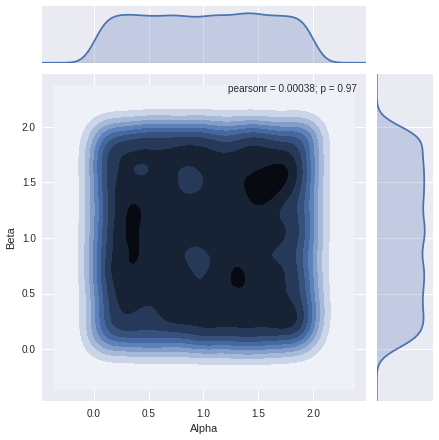

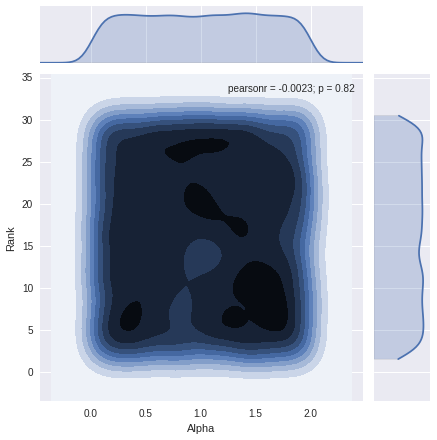

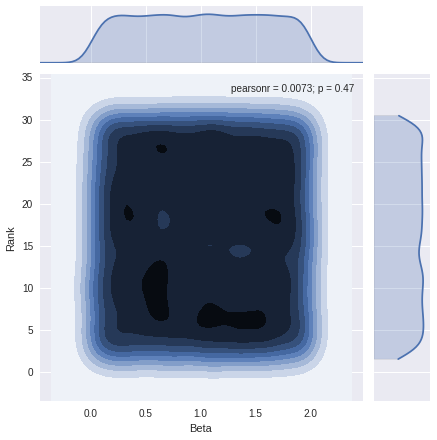

In [4]:
# Set search ranges
search_alpha_log = [0.01, 2.0]
search_beta_log = [0.01, 2.0]
search_rank = [2, 31]
n_search = 10000

# Generate parameter set
param_set = []
param_alpha = np.zeros(n_search)
param_beta = np.zeros(n_search)
param_rank = np.zeros(n_search)
for ii in xrange(n_search):
    alpha = np.random.uniform(low=search_alpha_log[0],
                              high=search_alpha_log[1])

    beta = np.random.uniform(low=search_beta_log[0],
                             high=search_beta_log[1])
    
    rank = np.random.randint(low=search_rank[0],
                             high=search_rank[1])
    
    param_alpha[ii] = alpha
    param_beta[ii] = beta
    param_rank[ii] = rank
    param_set.append({'id': ii+1,
                      'alpha': alpha,
                      'beta': beta,
                      'rank': rank})

    
# Display Joint-Distributions Parameter Space
%matplotlib inline
g = sns.jointplot(param_alpha, param_beta, kind='kde')
g.set_axis_labels('Alpha', 'Beta')

g = sns.jointplot(param_alpha, param_rank, kind='kde')
g.set_axis_labels('Alpha', 'Rank')

g = sns.jointplot(param_beta, param_rank, kind='kde')
g.set_axis_labels('Beta', 'Rank')

np.savez('{}/NMF_Optimization.Params.npz'.format(path_ExpData), param_set=param_set)

## Run Non-Negative Matrix Factorization Algorithm
*__WARNING: Will Delete Existing Output__*

In [5]:
# Remove all existing output (retains pipe/pipeline definitions)
rm_outp = glob.glob("{}/NMF_Optimization.Param_*".format(path_ExpData))

for rm_type in [rm_outp]:
    for path in rm_type:
        try:
            os.remove(path)
        except:
            print("{} not found".format(path))

In [7]:
param_set = np.load('{}/NMF_Optimization.Params.npz'.format(path_ExpData))['param_set']
path_cfg_matr = glob.glob('{}/NMF_Optimization.CfgMatr.*.npz'.format(path_ExpData))
expr_list = [f.split('/')[-1].split('.')[-2] for f in path_cfg_matr]

proc_item = []
for expr_id, path in zip(expr_list, path_cfg_matr):
    for param in param_set:
        res_path = '{}/NMF_Optimization.Param_{}.{}.npz'.format(path_ExpData, param['id'], expr_id)
        if os.path.exists(res_path):
            continue
        else:
            proc_item.append({'expr_id': expr_id,
                              'path_cfg_matr': path,
                              'param': param})
print('There are {} jobs to process.'.format(len(proc_item)))
    
# Submit proc_item list as jobs to qsub
job_file = open('./e02-job-NMF_Optimization', 'w')
job_file.write('#!/bin/bash\n\n')
for pitem in proc_item:    
    stdout_path = '{}/NMF_Optimization.Param_{}.{}.stdout'.format(path_ExpData, pitem['param']['id'], pitem['expr_id'])
    stderr_path = '{}/NMF_Optimization.Param_{}.{}.stderr'.format(path_ExpData, pitem['param']['id'], pitem['expr_id'])
    
    py_str = './pywrap-nmf_optimization {} {} {} {} {} {} {}'.format(
        pitem['expr_id'], pitem['path_cfg_matr'],
        pitem['param']['id'], pitem['param']['alpha'], pitem['param']['beta'],
        pitem['param']['rank'], path_ExpData)

    cmd_str = 'qsub -cwd -o {} -e {}'.format(stdout_path, stderr_path)
    
    job_file.write('{} {}\n'.format(cmd_str, py_str))
job_file.close()    

There are 0 jobs to process.


## Analyze Parameter Search Space

In [3]:
import scipy.stats as stats

param_set = np.load('{}/NMF_Optimization.Params.npz'.format(path_ExpData))['param_set']
param_run = glob.glob('{}/NMF_Optimization.Param_*.*.npz'.format(path_ExpData))
n_param = len(param_run)

param_alpha = np.zeros(n_param)
param_beta = np.zeros(n_param)
param_rank = np.zeros(n_param)

err = np.zeros(n_param)
subnet_sparsity = np.zeros(n_param)
coef_sparsity = np.zeros(n_param)

ii = 0
for path in param_run:
    if (ii % 500) == 0:
        print('Processed optimization: {} of {}'.format(ii, n_param))
    
    try:
        data = np.load(path, mmap_mode='r')
    except:
        continue
    
    p_id = int(path.split('/')[-1].split('.')[1].split('_')[1])
    param_alpha[ii] = param_set[p_id-1]['alpha']
    param_beta[ii] = param_set[p_id-1]['beta']
    param_rank[ii] = param_set[p_id-1]['rank']

    err[ii] = data['err'][-1]
    subnet_sparsity[ii] = (data['fac_subnet'] == 0).mean()
    coef_sparsity[ii] = (data['fac_coef'] == 0).mean()
    
    ii += 1
    data.close()

param_alpha = param_alpha[:ii]
param_beta = param_beta[:ii]
param_rank = param_rank[:ii]

err = err[:ii]
subnet_sparsity = subnet_sparsity[:ii]
coef_sparsity = coef_sparsity[:ii]

Processed optimization: 0 of 20000


Exception AttributeError: "'NpzFile' object has no attribute 'zip'" in <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7effbc9438d0>> ignored


Processed optimization: 500 of 20000
Processed optimization: 1000 of 20000
Processed optimization: 1500 of 20000
Processed optimization: 2000 of 20000
Processed optimization: 2500 of 20000
Processed optimization: 3000 of 20000
Processed optimization: 3500 of 20000
Processed optimization: 4000 of 20000
Processed optimization: 4500 of 20000
Processed optimization: 5000 of 20000
Processed optimization: 5500 of 20000
Processed optimization: 6000 of 20000
Processed optimization: 6500 of 20000
Processed optimization: 7000 of 20000
Processed optimization: 7500 of 20000


Exception AttributeError: "'NpzFile' object has no attribute 'zip'" in <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7eff95d3bc90>> ignored
Exception AttributeError: "'NpzFile' object has no attribute 'zip'" in <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7eff95d3bc10>> ignored


Processed optimization: 8000 of 20000
Processed optimization: 8500 of 20000
Processed optimization: 9000 of 20000
Processed optimization: 9500 of 20000
Processed optimization: 10000 of 20000
Processed optimization: 10500 of 20000
Processed optimization: 11000 of 20000
Processed optimization: 11500 of 20000
Processed optimization: 12000 of 20000
Processed optimization: 12500 of 20000
Processed optimization: 13000 of 20000
Processed optimization: 13500 of 20000
Processed optimization: 14000 of 20000
Processed optimization: 14500 of 20000
Processed optimization: 15000 of 20000
Processed optimization: 15500 of 20000
Processed optimization: 16000 of 20000
Processed optimization: 16500 of 20000
Processed optimization: 17000 of 20000
Processed optimization: 17500 of 20000
Processed optimization: 18000 of 20000
Processed optimization: 18500 of 20000
Processed optimization: 19000 of 20000
Processed optimization: 19500 of 20000


Exception AttributeError: "'NpzFile' object has no attribute 'zip'" in <bound method NpzFile.__del__ of <numpy.lib.npyio.NpzFile object at 0x7effbc9438d0>> ignored


### Display Parameter Search Space

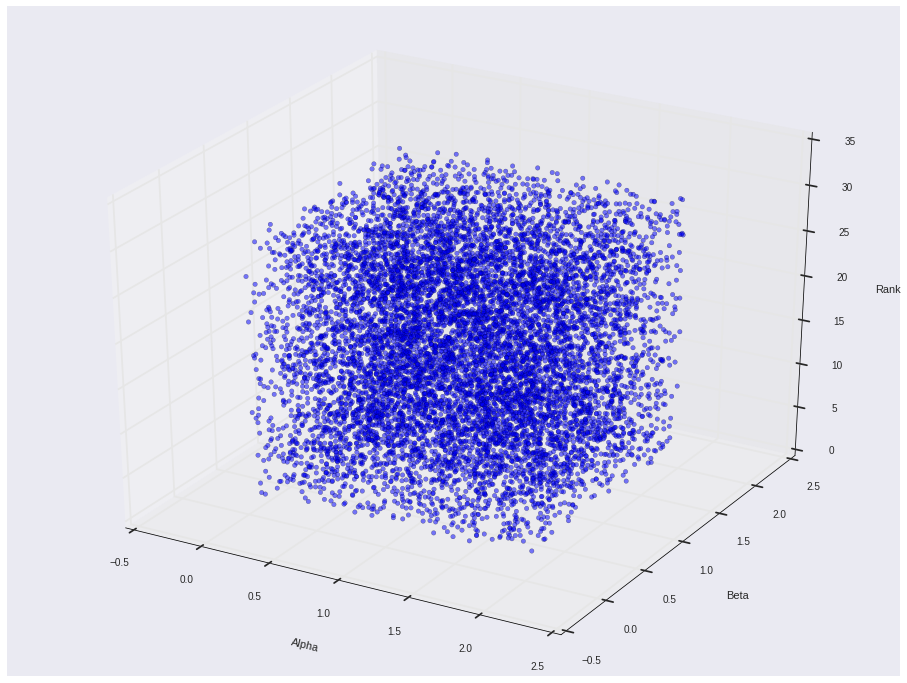

In [4]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(param_alpha, param_beta, param_rank, alpha=0.3)
ax.set_xlabel('Alpha')
ax.set_ylabel('Beta')
ax.set_zlabel('Rank')

### Display Relationship Between Parameters and Quality Measures

Plotting -- Residual Error
Plotting -- Pct Subgraph Sparse
Plotting -- Pct Coef Sparse


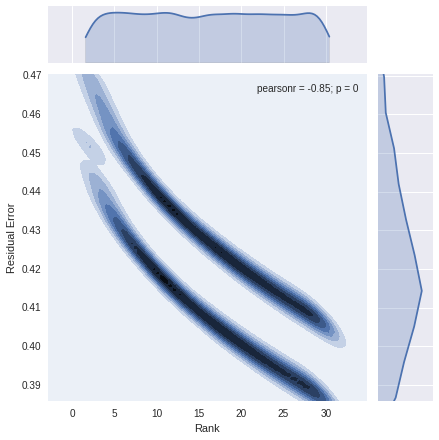

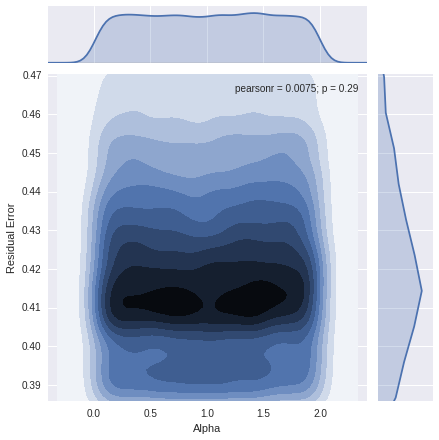

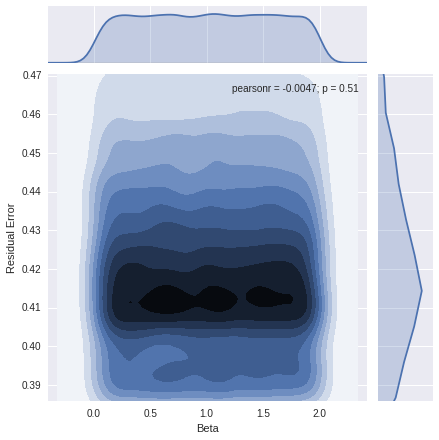

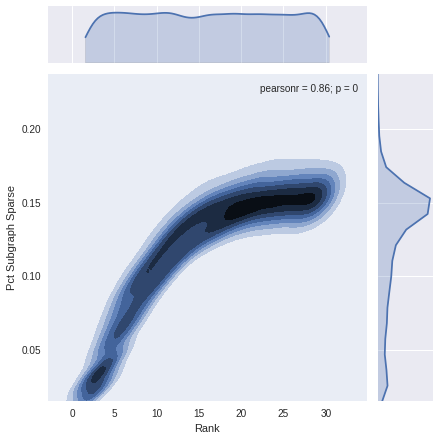

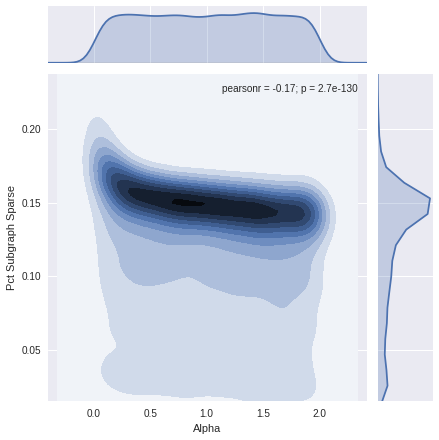

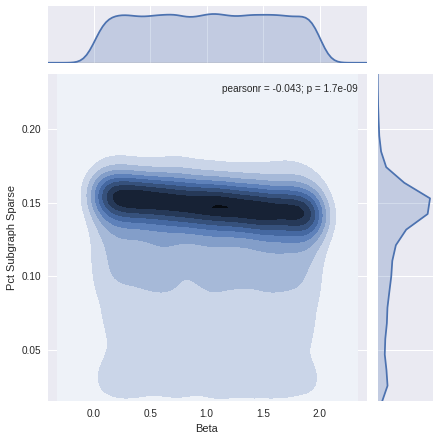

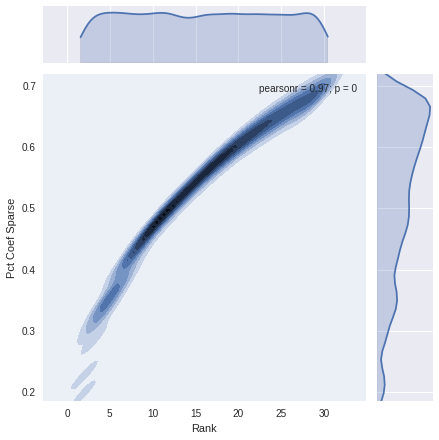

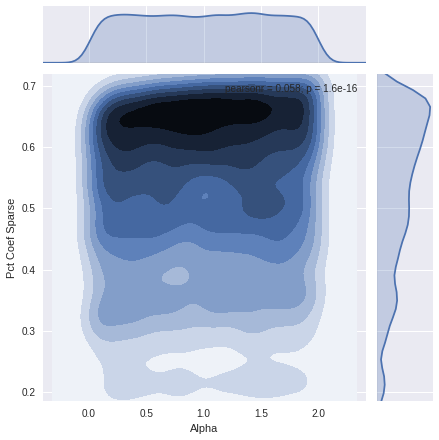

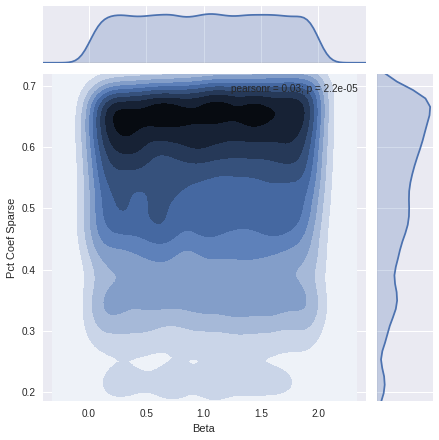

In [5]:
%matplotlib inline

for qmeas, qname in [(err, 'Residual Error'),
                     (subnet_sparsity, 'Pct Subgraph Sparse'),
                     (coef_sparsity, 'Pct Coef Sparse')]:
    print('Plotting -- {}'.format(qname))
    
    g = sns.jointplot(param_rank, qmeas, kind='kde',
                       ylim=[np.min(qmeas), np.max(qmeas)])
    g.set_axis_labels('Rank', qname)

    g = sns.jointplot((param_alpha), qmeas, kind='kde',
                       ylim=[np.min(qmeas), np.max(qmeas)])
    g.set_axis_labels('Alpha', qname)

    g = sns.jointplot((param_beta), qmeas, kind='kde',
                       ylim=[np.min(qmeas), np.max(qmeas)])
    g.set_axis_labels('Beta', qname)

### Display Bivariate Distribution of Error and Sparsity

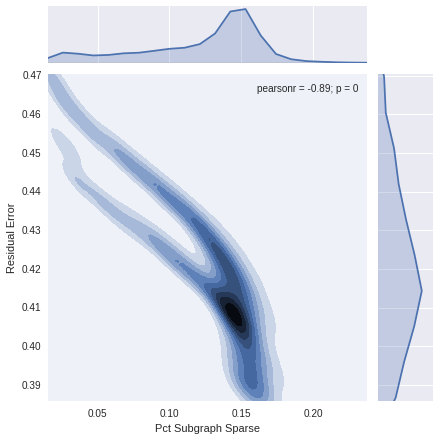

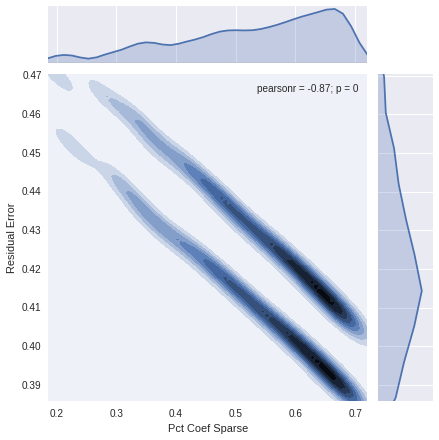

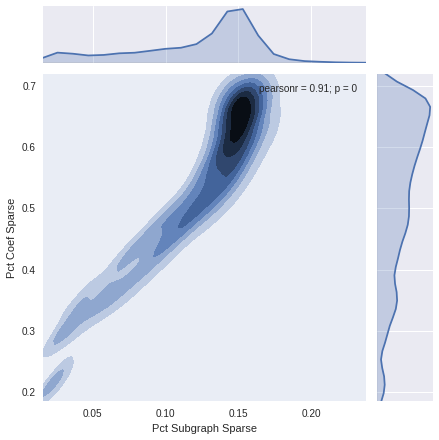

In [6]:
g = sns.jointplot(subnet_sparsity, err, kind='kde',
                  xlim=[np.min(subnet_sparsity), np.max(subnet_sparsity)],
                  ylim=[np.min(err), np.max(err)])
g.set_axis_labels('Pct Subgraph Sparse', 'Residual Error')

g = sns.jointplot(coef_sparsity, err, kind='kde',
                  xlim=[np.min(coef_sparsity), np.max(coef_sparsity)],
                  ylim=[np.min(err), np.max(err)])
g.set_axis_labels('Pct Coef Sparse', 'Residual Error')

g = sns.jointplot(subnet_sparsity, coef_sparsity, kind='kde',
                  xlim=[np.min(subnet_sparsity), np.max(subnet_sparsity)],
                  ylim=[np.min(coef_sparsity), np.max(coef_sparsity)])
g.set_axis_labels('Pct Subgraph Sparse', 'Pct Coef Sparse')

### Find Optimal Parameters

Minimize the residual error and maximize subgraph and temporal coefficient sparsity

In [7]:
# Specify ranges
err_range = [np.percentile(err, 0), np.percentile(err, 25)]
subnet_sparsity_range = [np.percentile(subnet_sparsity, 75), np.percentile(subnet_sparsity, 100)]
coef_sparsity_range = [np.percentile(coef_sparsity, 75), np.percentile(coef_sparsity, 100)]

err_ix = np.flatnonzero((err >= err_range[0]) & (err <= err_range[1]))
subnet_sparsity_ix = np.flatnonzero((subnet_sparsity >= subnet_sparsity_range[0]) &
                                    (subnet_sparsity <= subnet_sparsity_range[1]))
coef_sparsity_ix = np.flatnonzero((coef_sparsity >= coef_sparsity_range[0]) &
                                    (coef_sparsity <= coef_sparsity_range[1]))

param_ix = np.intersect1d(np.intersect1d(err_ix, subnet_sparsity_ix), coef_sparsity_ix)
n_param = len(param_ix)

print('Alpha: {} +/- {}'.format(np.mean(param_alpha[param_ix]),
                                np.std(param_alpha[param_ix]) / np.sqrt(n_param)))
print('Beta: {} +/- {}'.format(np.mean(param_beta[param_ix]),
                               np.std(param_beta[param_ix]) / np.sqrt(n_param)))
print('Rank: {} +/- {}'.format(np.mean(param_rank[param_ix]),
                               np.std(param_rank[param_ix]) / np.sqrt(n_param)))

Alpha: 0.909671081666 +/- 0.0114649440449
Beta: 0.907164545287 +/- 0.0120652745003
Rank: 27.2293307087 +/- 0.0470054563171


### Plot closest optimization example

Plotting Stroop Subgraphs...


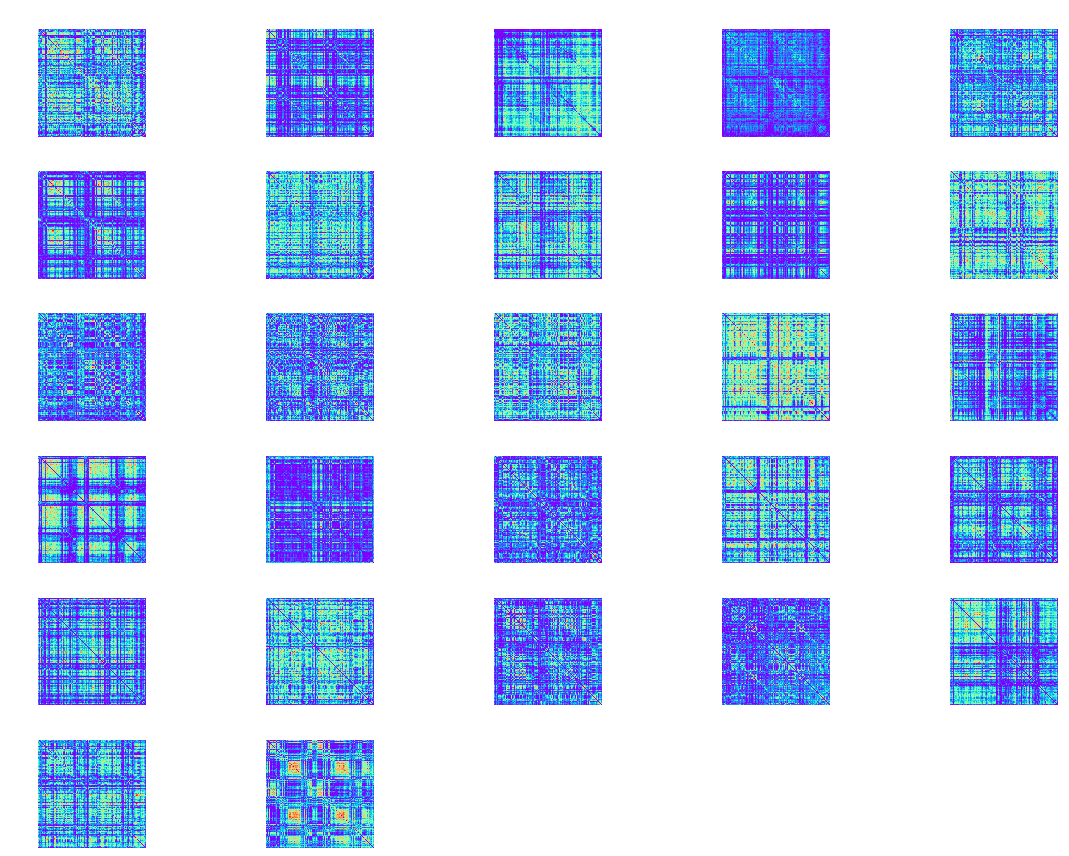

Plotting Navon Subgraphs...


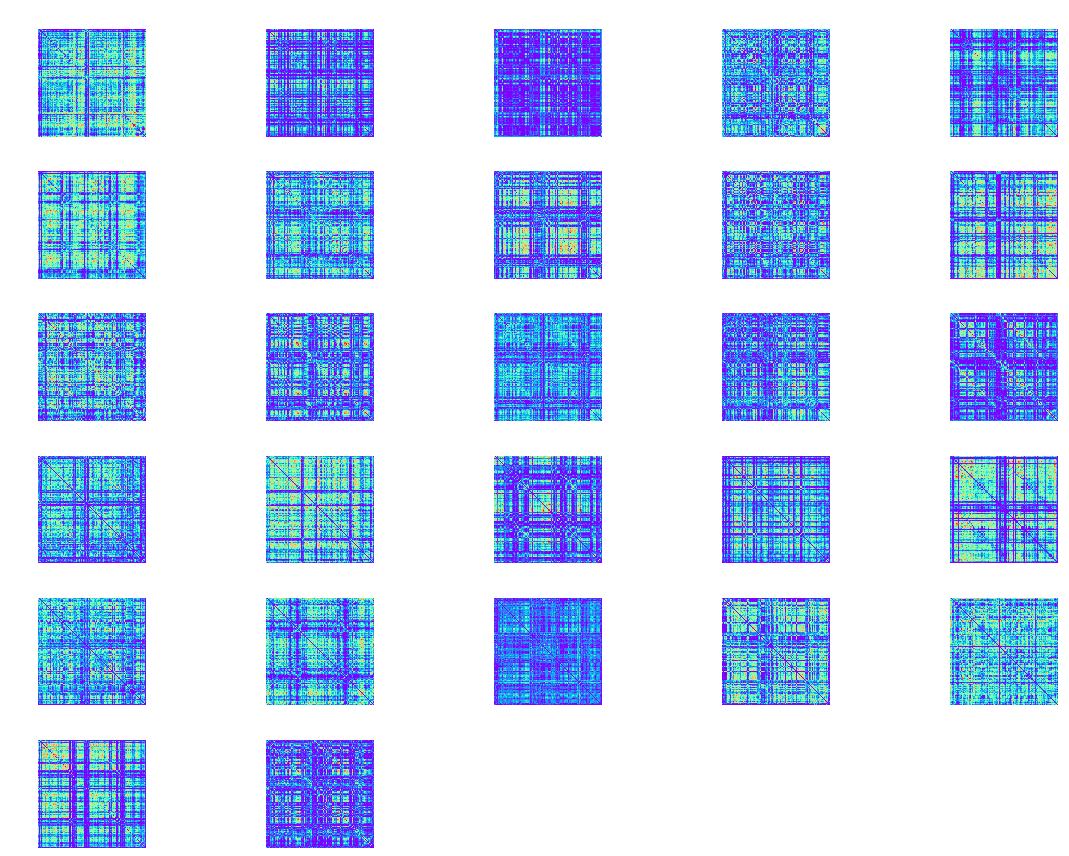

In [11]:
# Find param id that is a close match to optimal
opt_alpha = 0.91
opt_beta = 0.91
opt_rank = 27

param_set = np.load('{}/NMF_Optimization.Params.npz'.format(path_ExpData))['param_set']
param_rank = np.array([p['rank'] for p in param_set])
param_beta = np.array([p['beta'] for p in param_set])
param_alpha = np.array([p['alpha'] for p in param_set])

opt_rank_ix = np.flatnonzero(param_rank == opt_rank)
opt_beta_ix = np.argsort(np.abs(param_beta - opt_beta))[:1000]
opt_alpha_ix = np.argsort(np.abs(param_alpha - opt_alpha))[:1000]

opt_ix = np.intersect1d(np.intersect1d(opt_rank_ix, opt_beta_ix), opt_alpha_ix)[1]

# Plot Stroop
print('Plotting Stroop Subgraphs...')
df = np.load('{}/NMF_Optimization.Param_{}.Stroop.npz'.format(path_ExpData, opt_ix+1))
rank = df['fac_subnet'].shape[0]
n_col = int(np.sqrt(rank))
n_row = int(np.ceil(rank / n_col))

%matplotlib inline
plt.figure(figsize=(16, 12))
for ii in xrange(opt_rank):
    ax = plt.subplot(n_row, n_col, ii+1)
    ax.matshow(conv_cfg_vec_to_adj_matr(df['fac_subnet'][ii, :]), cmap='rainbow')
    ax.set_axis_off()
plt.show()

# Plot Navon
print('Plotting Navon Subgraphs...')
df = np.load('{}/NMF_Optimization.Param_{}.Navon.npz'.format(path_ExpData, opt_ix+1))
rank = df['fac_subnet'].shape[0]
n_col = int(np.sqrt(rank))
n_row = int(np.ceil(rank / n_col))

%matplotlib inline
plt.figure(figsize=(16, 12))
for ii in xrange(opt_rank):
    ax = plt.subplot(n_row, n_col, ii+1)
    ax.matshow(conv_cfg_vec_to_adj_matr(df['fac_subnet'][ii, :]), cmap='rainbow')
    ax.set_axis_off()
plt.show()

# Detect Dynamic Subgraphs

## Initialize Environment

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    
except:
    print 'NOT IPYTHON'

from __future__ import division
from IPython.display import display

import os
import sys
import glob
import json
import subprocess

import numpy as np
import pandas as pd
import seaborn as sns
import scipy.io as io
import h5py
import matplotlib.pyplot as plt
from matplotlib import rcParams

import fig_plotting
rcParams = fig_plotting.update_rcparams(rcParams)

import scipy.stats as stats

os.chdir('../')
import Codebase
conv_adj_matr_to_cfg_matr = Codebase.Networks.configuration.convert_adj_matr_to_cfg_matr
conv_cfg_vec_to_adj_matr = Codebase.Networks.configuration.convert_conn_vec_to_adj_matr
os.chdir('./Analysis Notebooks/')

path_CoreData = '/home/akhambhati/JagHome/hoth_research/CoreData/Sync_Cog_Control-Medaglia'
path_PeriphData = '/home/akhambhati/JagHome/hoth_research/PeriphData/ds-NMF_CogControl'
path_InpData = path_PeriphData + '/e01-FuncNetw'
path_ExpData = path_PeriphData + '/e02-FuncSubg'

for path in [path_CoreData, path_PeriphData, path_ExpData]:
    if not os.path.exists(path):
        print('Path: {}, does not exist'.format(path))
        os.makedirs(path)

/home/akhambhati/Developer/miniconda2/envs/cb-nmfsubnet/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Run Non-Negative Matrix Factorization Algorithm
*__WARNING: Will Delete Existing Output__*

In [15]:
# Remove all existing output (retains pipe/pipeline definitions)
rm_outp = glob.glob("{}/NMF_Optimized.Seed_*".format(path_ExpData))

for rm_type in [rm_outp]:
    for path in rm_type:
        try:
            os.remove(path)
        except:
            print("{} not found".format(path))

In [2]:
# Optimal Parameter Set
opt_alpha = 0.91
opt_beta = 0.91
opt_rank = 27
n_seed = 1000

param_set = []
for seed in xrange(n_seed):
    param_set.append({'id': seed+1,
                      'alpha': opt_alpha,
                      'beta': opt_beta,
                      'rank': opt_rank})
    

path_cfg_matr = glob.glob('{}/NMF_Optimization.CfgMatr.*.npz'.format(path_ExpData))
expr_list = [f.split('/')[-1].split('.')[-2] for f in path_cfg_matr]

proc_item = []
for expr_id, path in zip(expr_list, path_cfg_matr):
    for param in param_set:
        res_path = '{}/NMF_Optimized.Seed_{}.{}.npz'.format(path_ExpData, param['id'], expr_id)
        if os.path.exists(res_path):
            continue
        else:
            proc_item.append({'expr_id': expr_id,
                              'path_cfg_matr': path,
                              'param': param})
print('There are {} jobs to process.'.format(len(proc_item)))
    
# Submit proc_item list as jobs to qsub
job_file = open('./e02-job-NMF_Optimized', 'w')
job_file.write('#!/bin/bash\n\n')
for pitem in proc_item:    
    stdout_path = '{}/NMF_Optimized.Seed_{}.{}.stdout'.format(path_ExpData, pitem['param']['id'], pitem['expr_id'])
    stderr_path = '{}/NMF_Optimized.Seed_{}.{}.stderr'.format(path_ExpData, pitem['param']['id'], pitem['expr_id'])
    
    py_str = './pywrap-nmf_optimized {} {} {} {} {} {} {}'.format(
        pitem['expr_id'], pitem['path_cfg_matr'],
        pitem['param']['id'], pitem['param']['alpha'], pitem['param']['beta'],
        pitem['param']['rank'], path_ExpData)

    cmd_str = 'qsub -cwd -o {} -e {}'.format(stdout_path, stderr_path)
    
    job_file.write('{} {}\n'.format(cmd_str, py_str))
job_file.close()    

There are 0 jobs to process.


## Consensus NMF

In [2]:
from Codebase.Networks.SubgraphDetection.nonnegfac import nmf

n_subset_seed = 100

path_cfg_matr = glob.glob('{}/NMF_Optimization.CfgMatr.*.npz'.format(path_ExpData))
expr_list = [f.split('/')[-1].split('.')[-2] for f in path_cfg_matr]

for expr_id, cfg_path in zip(expr_list, path_cfg_matr):
    seed_path = np.random.permutation(glob.glob('{}/NMF_Optimized.Seed_*.{}.npz'.format(path_ExpData, expr_id)))
    seed_path = seed_path[:n_subset_seed]
    
    # Concatenate subgraphs from all seeds
    fac_subnet_seeds = []
    for ix, path in enumerate(seed_path):
        data = np.load(path, mmap_mode='r')
        fac_subnet = data['fac_subnet'][:, :]
        data.close()
        
        n_fac = fac_subnet.shape[0]
        n_conn = fac_subnet.shape[1]

        for ix in xrange(fac_subnet.shape[0]):
            fac_subnet_seeds.append(fac_subnet[ix, :])
    fac_subnet_seeds = np.array(fac_subnet_seeds)
    
    n_obs = fac_subnet_seeds.shape[0]
    n_conn = fac_subnet_seeds.shape[1]

    # Consensus Subgraphs
    fac_cons_subnet, fac_cons_seeds, err = nmf.snmf_bcd(
        fac_subnet_seeds,
        alpha=0.0,
        beta=0.0,
        fac_subnet_init=np.random.uniform(low=0.0, high=1.0, size=(n_fac, n_conn)),
        fac_coef_init=np.random.uniform(low=0.0, high=1.0, size=(n_fac, n_obs)),
        max_iter=100, verbose=True)
    
    # Consensus Coefficients
    data_cfg = np.load(cfg_path, mmap_mode='r')
    cfg_matr = np.nan_to_num(data_cfg['cfg_matr'][:, :])
    n_win = cfg_matr.shape[0]
    fac_cons_subnet_2, fac_cons_coef_2, err = nmf.snmf_bcd(
        cfg_matr,
        alpha=0.0,
        beta=0.0,
        fac_subnet_init=fac_cons_subnet,
        fac_coef_init=np.random.uniform(low=0.0, high=1.0, size=(n_fac, n_win)),
        max_iter=100, verbose=True)
    
    # Cache the Consensus NMF result
    np.savez("{}/NMF_Consensus.{}.npz".format(path_ExpData, expr_id),
             fac_subnet=fac_cons_subnet_2, fac_coef=fac_cons_coef_2, err=err)


Beginning Non-Negative Matrix Factorization


Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:55: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
Codebase/Networks/SubgraphDetection/nonnegfac/nnls.py:290: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.



Done.

Beginning Non-Negative Matrix Factorization

Done.

Beginning Non-Negative Matrix Factorization

Done.

Beginning Non-Negative Matrix Factorization

Done.


## Consensus Subgraphs

Plotting Stroop Subgraphs...


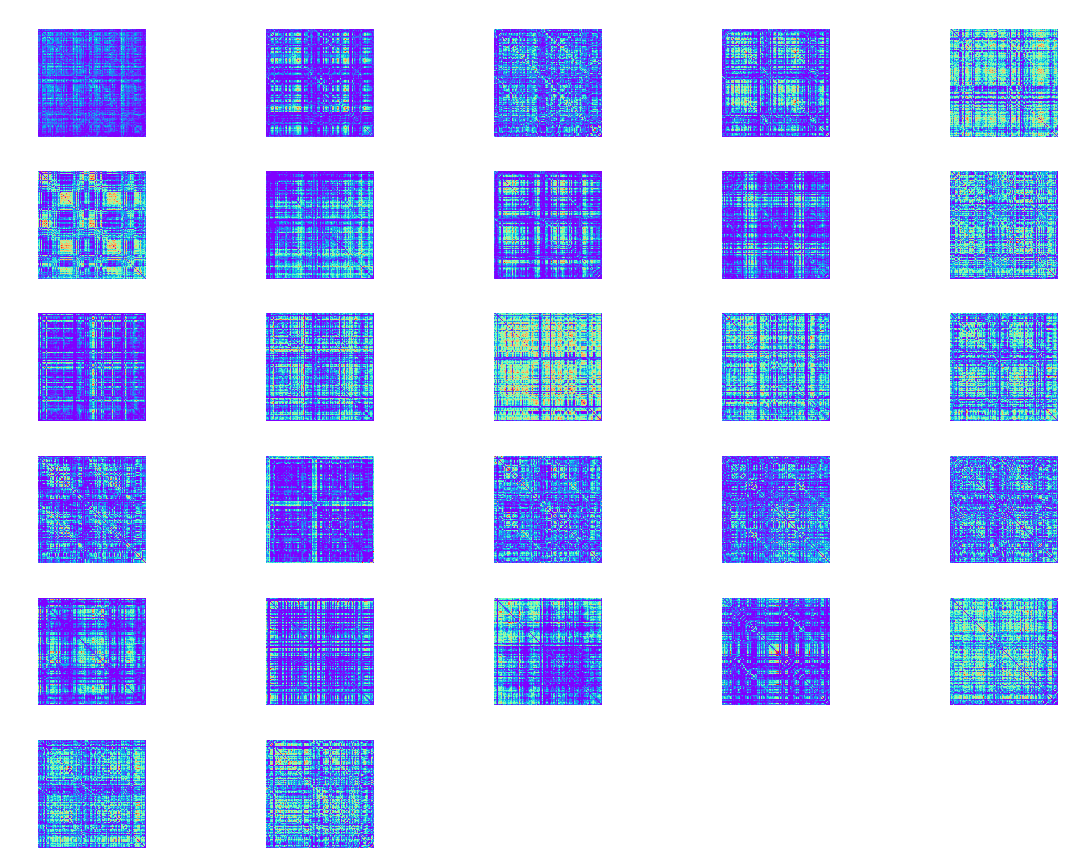

Plotting Navon Subgraphs...


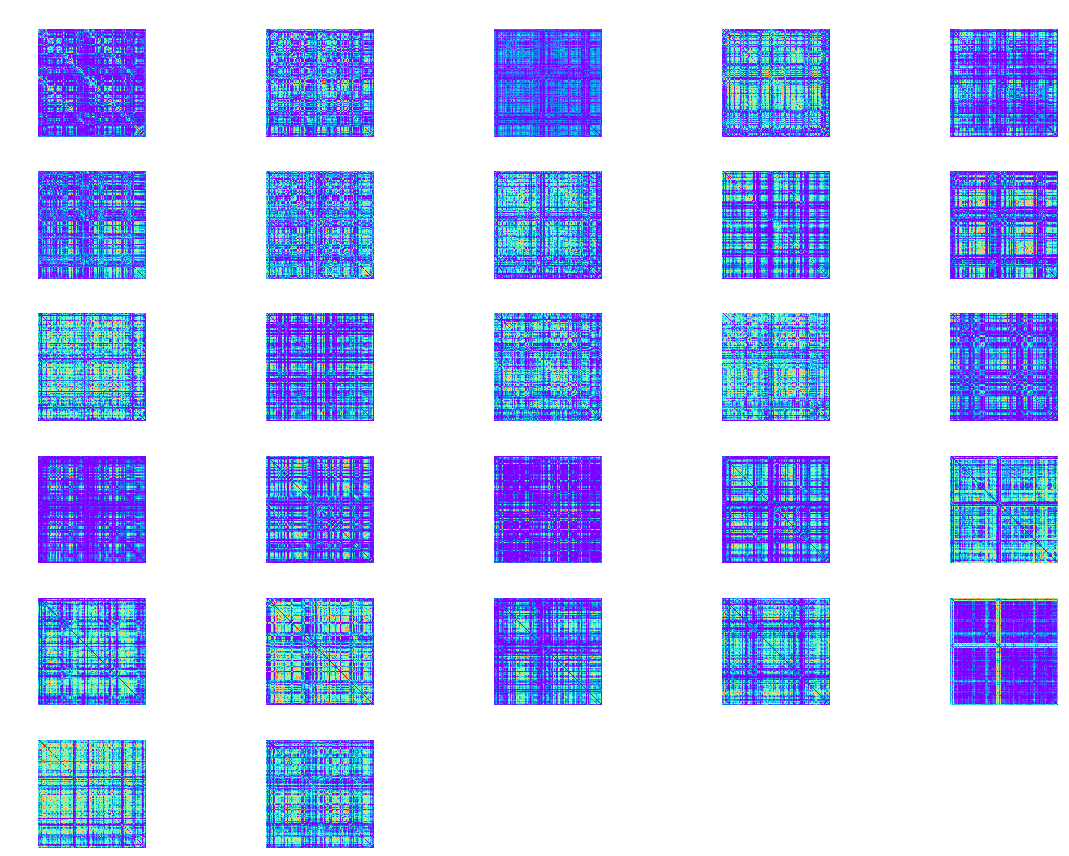

In [6]:
# Plot Stroop
print('Plotting Stroop Subgraphs...')
df = np.load('{}/NMF_Consensus.Stroop.npz'.format(path_ExpData))
rank = df['fac_subnet'].shape[0]
n_col = int(np.sqrt(rank))
n_row = int(np.ceil(rank / n_col))

%matplotlib inline
plt.figure(figsize=(16, 12))
for ii in xrange(rank):
    ax = plt.subplot(n_row, n_col, ii+1)
    ax.matshow(conv_cfg_vec_to_adj_matr(df['fac_subnet'][ii, :]), cmap='rainbow')
    ax.set_axis_off()
plt.show()


# Plot Navon
print('Plotting Navon Subgraphs...')
df = np.load('{}/NMF_Consensus.Navon.npz'.format(path_ExpData))
rank = df['fac_subnet'].shape[0]
n_col = int(np.sqrt(rank))
n_row = int(np.ceil(rank / n_col))

%matplotlib inline
plt.figure(figsize=(16, 12))
for ii in xrange(rank):
    ax = plt.subplot(n_row, n_col, ii+1)
    ax.matshow(conv_cfg_vec_to_adj_matr(df['fac_subnet'][ii, :]), cmap='rainbow')
    ax.set_axis_off()
plt.show()

In [2]:
df_stroop = np.load('{}/NMF_Consensus.Stroop.npz'.format(path_ExpData))
df_navon = np.load('{}/NMF_Consensus.Navon.npz'.format(path_ExpData))

n_null = 1000
n_thr = 0.010
n_fac = df_stroop['fac_subnet'].shape[0]

null_stroop_subg = np.dot(np.random.random(size=(n_null, n_fac)), df_stroop['fac_subnet'])
null_navon_subg = np.dot(np.random.random(size=(n_null, n_fac)), df_navon['fac_subnet'])

matching_pairs = []
count = 1
for stroop_ix, stroop_subg in enumerate(df_stroop['fac_subnet']):
    for navon_ix, navon_subg in enumerate(df_navon['fac_subnet']):
        true_rho, true_pval = stats.pearsonr(stroop_subg, navon_subg)
        
        stroop_rnd_rho = []
        navon_rnd_rho = []
        for ii in xrange(n_null):
            null_rho, _ = stats.pearsonr(null_stroop_subg[ii,:], navon_subg)
            stroop_rnd_rho.append(null_rho)

            null_rho, _ = stats.pearsonr(null_navon_subg[ii,:], stroop_subg)
            navon_rnd_rho.append(null_rho)
        stroop_pval = np.mean(np.array(stroop_rnd_rho) > true_rho)
        navon_pval = np.mean(np.array(navon_rnd_rho) > true_rho)        
        
        if (stroop_pval < n_thr) and (navon_pval < n_thr):
            is_match = True
        else:
            is_match = False
        match = (stroop_ix, navon_ix, true_rho, stroop_pval, navon_pval, is_match)
        matching_pairs.append(match)
        print(count, match)
        
        count += 1
matching_pairs = np.array(matching_pairs)

# Cache the matching pairs result
np.savez("{}/NMF_Matching_Pairs.npz".format(path_ExpData),
         matching_pairs=matching_pairs)

(1, (0, 0, 0.12604838556007328, 1.0, 0.073999999999999996, False))
(2, (0, 1, -0.063447338106408638, 1.0, 0.999, False))
(3, (0, 2, 0.32087431643593123, 0.066000000000000003, 0.0, False))
(4, (0, 3, 0.18292099714993984, 0.998, 0.002, False))
(5, (0, 4, 0.19362181994584929, 0.023, 0.002, False))
(6, (0, 5, -0.039215694486510994, 1.0, 0.99399999999999999, False))
(7, (0, 6, -0.015927596679760021, 1.0, 0.98199999999999998, False))
(8, (0, 7, 0.16454502165563833, 1.0, 0.0040000000000000001, False))
(9, (0, 8, -0.076089040516617718, 1.0, 1.0, False))
(10, (0, 9, -0.051436817780690147, 1.0, 0.999, False))
(11, (0, 10, 0.13048959275177097, 1.0, 0.051999999999999998, False))
(12, (0, 11, 0.039323324017972235, 1.0, 0.79500000000000004, False))
(13, (0, 12, 0.052663750984834785, 1.0, 0.69999999999999996, False))
(14, (0, 13, -0.074809550162768523, 1.0, 1.0, False))
(15, (0, 14, -0.026531863594998716, 1.0, 0.99299999999999999, False))
(16, (0, 15, 0.020957436062931788, 0.53100000000000003, 0.8930

In [17]:
cand_match_ix = np.flatnonzero(matching_pairs[:, -1])

print('STROOP')
stroop_cand = np.unique(matching_pairs[cand_match_ix, 0])
for cand in stroop_cand:
    ix = np.flatnonzero(matching_pairs[cand_match_ix, 0] == cand)
    print(ix)

print('NAVON')
navon_cand = matching_pairs[cand_match_ix, 1]
for cand in navon_cand:
    ix = np.flatnonzero(matching_pairs[cand_match_ix, 1] == cand)
    print(ix)



STROOP
[0]
[1]
[2 3]
[4 5]
[6]
[7]
[8 9]
[10]
[11]
[12]
[13 14]
[15 16]
[17]
[18]
[19]
[20]
[21]
[22]
NAVON
[0]
[1]
[2 5 9]
[ 3 15]
[4]
[2 5 9]
[6]
[7]
[ 8 13]
[2 5 9]
[10 18]
[11]
[12]
[ 8 13]
[14]
[ 3 15]
[16]
[17]
[10 18]
[19]
[20]
[21]
[22]
